# PVLIB Testing

## Environment installation
Plugin jupyter & python 

### kernel
https://ipython.readthedocs.io/en/stable/install/kernel_install.html

conda create -n ipykernel_py2 python=2 ipykernel
source activate ipykernel_py2    # On Windows, remove the word 'source'
python -m ipykernel install --use

source activate myenv
conda install pip
conda install ipykernel # or pip install ipykernel

## installation order
pvlib (using pandas)
matplotlib

## PVsyst annex

Batch
C:\Users\wsfm\PVsyst7.0_Data\UserBatch

## Libraries import

In [28]:
import os
import matplotlib
import numpy as np
import pandas as pd
import pvlib

## Global variables

In [29]:
PVSYST_FOLDER = r"C:\Users\wsfm\PVsyst7.0_Data\UserHourly"
PVSYST_HOURLY_FILE = r"Project_test_221012_Project_VC0_HourlyRes_7.csv"
PVSYST_HOURLY_METEO = r"Loughborough_meteo.csv"
#PVSYST_HOURLY_FILE = r"Project_test_221012_Project_VC0_HourlyRes_5 - Copy.csv"

## Note
For PVsyst only global horizontal can be imported

## Solar Geometry
Not needed since measured global on plane

### PVsyst

Sun height   (HSun)	Angle between the sun's direction and the horizontal plane
Sin (HSun)  =   Sin (Lat) * Sin (Decl) + Cos (Lat) * Cos (Decl) * Cos (HA)


Incidence Angle	Angle between the sun's ray and the normal to the plane
cos (IA)  =  cos  (AzSun - AzimPl)  *  cos (HSun) * sin (InclPl)  +  sin (HSun) * cos (InclPl)

### Clearness Index Kt (not available as result)
The Clearness Index Kt  is defined as the ratio of the horizontal global irradiance to the corresponding irradiance available outside of the atmosphere  (i.e. the  extraterrestrial irradiance multiplied by the sinus of the sun height).

The extraterrestrial irradiance is the Solar constant  (1361 W/m²)  corrected by a yearly sinus function of amplitude 3.3% accounting for earth's orbit ellipticity.

Therefore the Clearness Index Kt may be considered as an attenuation factor of the atmosphere.
 
The monthly average of Kt should usually lie between about Kt = 0.12 and Kt = 0.82 at any place and for any month. If these limits are exceeded (in very particular cases), you may modify them in the "Advanced parameters", topic "Size and Meteo".



## Hay Davies 

DiffInc  = DiffHor *  [  (1-Kb)  *  (1 + cos i) / 2  +  Kb * sin HsolI / sin Hsol ]


### Differences in part Kb * sin HsolI / sin Hsol

pvsyst:

Kb * sin HsolI / sin Hsol = BeamHor / (Io * Sin Hsol) * sin HsolI / sin Hso

formulation with pvlib references

dni / (dni_extra * cos_tt) * cos_tt / cos_solar_zenith


pvlib:

AI * Rb = 

dni / dni_extra * cos_tt / np.maximum(cos_solar_zenith, 0.01745) =




cos_tt = aoi_projection(surface_tilt, surface_azimuth,
                                solar_zenith, solar_azimuth)
        cos_tt = np.maximum(cos_tt, 0)  # GH 526
        cos_solar_zenith = tools.cosd(solar_zenith)
        Rb = cos_tt / np.maximum(cos_solar_zenith, 0.01745)  #





### pvsyst

 DiffInc  = DiffHor *  [  (1-Kb)  *  (1 + cos i) / 2  +  Kb * sin HsolI / sin Hsol ]

Kb    = Clearness index of beam =  BeamHor / (Io * Sin Hsol)
Hsol  = Sun height on horizontal plane
Hsoli = Sun height on the plane   (= 90° - incidence angle)


The Albedo component is the irradiance reflected by the ground  "seen" by the plane :

   AlbInc = ρ  *  GlobHor  *   (1 - cos i) / 2

where 
i        = Plane tilt 
Hsol  = Sun height on horizontal plane
Hsoli = Sun height on the plane   (= 90° - incidence angle)
Kb    = Clearness index of beam =  BeamHor / (Io * Sin Hsol)
Io      = Solar constant  (depends on the day of year)
ρ      = Albedo coefficient  (usual value 0.2)

### pvlib transposition

 I_{d} = DHI ( A R_b + (1 - A) (\frac{1 + \cos\beta}{2}) )

https://pvlib-python.readthedocs.io/en/v0.9.0/generated/pvlib.irradiance.haydavies.html
https://pvlib-python.readthedocs.io/en/v0.9.0/_modules/pvlib/irradiance.html#haydavies

projection_ratio : None or numeric, default None
        Ratio of angle of incidence projection to solar zenith angle
        projection. Must supply ``solar_zenith`` and ``solar_azimuth``
        or supply ``projection_ratio`

    surface_azimuth : numeric
        Surface azimuth angles in decimal degrees. The azimuth
        convention is defined as degrees east of north (e.g. North=0,
        South=180, East=90, West=270).

if projection_ratio is None:
        cos_tt = aoi_projection(surface_tilt, surface_azimuth,
                                solar_zenith, solar_azimuth)
        cos_tt = np.maximum(cos_tt, 0)  # GH 526
        cos_solar_zenith = tools.cosd(solar_zenith)
        Rb = cos_tt / np.maximum(cos_solar_zenith, 0.01745)  # GH 432


Anisotropy Index
AI = dni / dni_extra

 these are the () and [] sub-terms of the second term of eqn 7
 term1 = 1 - AI
 term2 = 0.5 * (1 + tools.cosd(surface_tilt))

 sky_diffuse = dhi * (AI * Rb + term1 * term2)
 sky_diffuse = np.maximum(sky_diffuse, 0)


### pvlib aoi projection

def aoi_projection(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth):
    """
    Calculates the dot product of the sun position unit vector and the surface
    normal unit vector; in other words, the cosine of the angle of incidence.

    Usage note: When the sun is behind the surface the value returned is
    negative.  For many uses negative values must be set to zero.

    Input all angles in degrees.

    Parameters
    ----------
    surface_tilt : numeric
        Panel tilt from horizontal.
    surface_azimuth : numeric
        Panel azimuth from north.
    solar_zenith : numeric
        Solar zenith angle.
    solar_azimuth : numeric
        Solar azimuth angle.

    Returns
    -------
    projection : numeric
        Dot product of panel normal and solar angle.
    """

    projection = (
        tools.cosd(surface_tilt) * tools.cosd(solar_zenith) +
        tools.sind(surface_tilt) * tools.sind(solar_zenith) *
        tools.cosd(solar_azimuth - surface_azimuth))

    # GH 1185
    projection = np.clip(projection, -1, 1)

    try:
        projection.name = 'aoi_projection'
    except AttributeError:
        pass

    return projection

In [30]:
surface_tilt = 34
surface_azimuth = 180
dhi = 12.304
dni = 0.0034
# https://www.pvsyst.com/help/clearness_index.htm
dni_extra= 1361
solar_zenith = 6.9246
solar_azimuth = -36.198

In [31]:
test = False
if test:
    # 'pyephem', 'spencer', 'asce', 'nrel'.
    pvlib.irradiance.get_extra_radiation(df.loc[:,"date"].values[0], solar_constant=1366.1, method="spencer", epoch_year=df.loc[:,"date"].dt.year.values[0])

try to multiple dni_extra with solar zenith like in PVsyst

In [32]:
test = False
if test:
    pvlib.irradiance.haydavies(surface_tilt, surface_azimuth, 
    dhi, dni, dni_extra, solar_zenith, solar_azimuth) #, projection_ratio=None)

In [33]:
def get_diffuse_haydavies_mod(surface_tilt, surface_azimuth, dhi, dni, dni_extra, solar_zenith, solar_azimuth,projection_ratio
=None):
    if projection_ratio is None:
        cos_tt = pvlib.irradiance.aoi_projection(surface_tilt, 360-surface_azimuth,
                                solar_zenith, solar_azimuth+180)
        cos_tt = np.maximum(cos_tt, 0)  # GH 526
        cos_solar_zenith = pvlib.irradiance.tools.cosd(solar_zenith)
        Rb = cos_tt / np.maximum(cos_solar_zenith, 0.01745)  # GH 432
        #Rb = cos_tt / cos_solar_zenith  

    else:
        Rb = projection_ratio

    # Anisotropy Index
    AI = dni / dni_extra

    # these are the () and [] sub-terms of the second term of eqn 7
    term1 = 1 - AI
    term2 = 0.5 * (1 + pvlib.irradiance.tools.cosd(surface_tilt))

    sky_diffuse = dhi * (AI * Rb + term1 * term2)
    sky_diffuse = np.maximum(sky_diffuse, 0)
    return sky_diffuse

In [34]:
test = False
if test:
    df.loc[df["diff_pr"]==np.nanmin(df["diff_pr"]), clms]

In [35]:
if test:
    dhi = df[3763,"54.303"]
    dni
    dni_extra
    solar_zenith
    solar_azimuth
    projection_ratio



    cos_tt = pvlib.irradiance.aoi_projection(surface_tilt, surface_azimuth,
                                    solar_zenith, solar_azimuth)

Testing all parameters for index 3763

In [36]:
def tdt(x): 
    return pd.to_datetime(x, format=r"%d/%m/%y %H:%M")

In [37]:
#not used
columns = ["date","GlobInc","GlobEff","EArrRef","EArrMPP","IArray","UArray","EArray","EOutInv","E_Grid","Yr","PR","Lc",
"EffInvR","GlobHor","DiffHor","BeamHor","HSol","AzSol","BeamTrp","DifITrp","CircTrp","HBndTrp","AlbTrp","GlobTrp",
"GincThr","DifSInc","Alb_Inc","CircInc"]

# encoding errors due to units values
df = pd.read_csv(filepath_or_buffer=os.path.join(PVSYST_FOLDER,PVSYST_HOURLY_FILE), encoding="utf-8-sig",
skiprows=10,   delimiter=",", encoding_errors="replace") #nrows=20,

df = df.iloc[1:]

df["date"] = df["date"].apply(tdt)

# df["date"] = pd.DatetimeIndex(df["date"])

df_dtypes = dict(zip(columns[1:],len(columns[1:])*[float]))

df = df.astype(df_dtypes)

df["year"] = df["date"].dt.year

#df.dtypes


In [38]:
df_mt = pd.read_csv(filepath_or_buffer=os.path.join(os.getcwd().replace("examples","data"),PVSYST_HOURLY_METEO), 
encoding="utf-8-sig",delimiter=";", encoding_errors="replace", usecols=[0,1,2,3,4,5,6]) #nrows=20,
df_mt["Interval beginning"] = df_mt["Interval beginning"].apply(tdt)
df_mt.rename(columns={"Interval beginning":"date"}, inplace=True)
df_mt["Io_sin_Hsol"] = df_mt.apply(lambda x: 0 if x["KT"] == 0 else x["GlobHor"]/x["KT"], axis=1)
# Direct normal irradiance (DNI or BeamNor)  are also available for concentrating systems.

In [39]:
df_mt = df_mt.merge(df[["date","HSol","AzSol","year"]], left_on="date", right_on="date", how="left")

In [40]:
solar_constant=1366.1

for method in ["spencer","pyephem","asce","nrel"]:
    df_mt["Io_"+method] = df_mt.apply(lambda x: pvlib.irradiance.get_extra_radiation(x["date"], 
    solar_constant=solar_constant, method=method, epoch_year=x["year"]), axis=1)  

In [41]:
df_mt["Io"] = df_mt.apply(lambda x: x["Io_sin_Hsol"]/pvlib.tools.sind(x["HSol"]) if x["HSol"]>0 else 0, axis=1)

In [42]:
# df_mt["Ionrel_dv"] = df_mt.apply(lambda x: 1-(x["Ionrel"]/x["Io"]) if x["Io"]>0 else 0, axis=1)


In [43]:
if test:
    df_mt.loc[df_mt["Io"]!=0,["Io","Ionrel","Ionrel_dv"]]

In [45]:
#df_mt.loc[df["diff_pr"]==np.nanmax(df["diff_pr"]), clms]

In [46]:
# Direct normal irradiance (DNI or BeamHor)  are also available for concentrating systems. 
# Navigation:  Meteo Database > Import known format meteo data > Solargis Data
test = False
if test:
    df.loc[df["date"]=="2015-06-06 18:00:00",["date","GlobHor","DiffHor","BeamHor","HSol","AzSol"]]

In [47]:
def aoi_projection(x):
    # # morning = solar_azimuth < 180
    # afternoon = solar_azimuth > 180
    return pvlib.irradiance.aoi_projection(surface_tilt, surface_azimuth, x["HSol"], x["AzSol"]+180)

In [48]:
df["aoi_projection"] =  df.apply(aoi_projection, axis=1)

In [49]:
def diffuse_from_x(x, method="spencer", projection=True):
    # 'pyephem', 'spencer', 'asce', 'nrel'.
    try: 
        if "projection":
            return get_diffuse_haydavies_mod(surface_tilt, surface_azimuth,x["DiffHor"], x["BeamHor"],      
            # dni_extra*x["aoi_projection"], 
            pvlib.irradiance.get_extra_radiation(x["date"], solar_constant=1366.1, method=method, epoch_year=x["year"])*x["aoi_projection"],
            x["HSol"], x["AzSol"]+180)  
        elif "projection" == False:
            return get_diffuse_haydavies_mod(surface_tilt, surface_azimuth,x["DiffHor"], x["BeamHor"],      
            # dni_extra*x["aoi_projection"], 
            pvlib.irradiance.get_extra_radiation(x["date"], solar_constant=1366.1, method=method, epoch_year=x["year"]),
            x["HSol"], x["AzSol"]+180)  

        """elif method == "":
            return pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,x["DiffHor"], x["BeamHor"], 
            # dni_extra*x["aoi_projection"], 
            pvlib.irradiance.get_extra_radiation(x["date"], solar_constant=1366.1, method="spencer", epoch_year=x["year"])*x["aoi_projection"],            
            x["HSol"], x["AzSol"]+180)"""    
    except TypeError:
        print(x["HSol"], x["AzSol"])
        return None

In [50]:
# execution 1.7s
df["poa_diffuse_spencer_prj"] = df.apply(lambda x: diffuse_from_x(x), axis=1)
df["poa_diffuse_spencer"] = df.apply(lambda x: diffuse_from_x(x, projection=False), axis=1)

In [51]:
# execution 8.9
df["poa_diffuse_pyephem_prj"] = df.apply(lambda x: diffuse_from_x(x, method="pyephem"), axis=1)
df["poa_diffuse_pyephem"] = df.apply(lambda x: diffuse_from_x(x, method="pyephem", projection=False), axis=1)

In [52]:
# execution 1.4s faster
df["poa_diffuse_asce_prj"] = df.apply(lambda x: diffuse_from_x(x, method="asce"), axis=1)
df["poa_diffuse_asce"] = df.apply(lambda x: diffuse_from_x(x, method="asce", projection=False), axis=1)

In [53]:
# execution 28.1s longer
df["poa_diffuse_nrel_prj"] = df.apply(lambda x: diffuse_from_x(x, method="nrel"), axis=1)
df["poa_diffuse_nrel"] = df.apply(lambda x: diffuse_from_x(x, method="nrel", projection=False), axis=1)

In [54]:
def dff_dff(x, method="spencer"):
    if  (x["DifITrp"] is not None) & (x["poa_diffuse_spencer"] is not None) & (x["DifITrp"] != 0):
        s = "poa_diffuse_" + method
        try:
            return (1-(x[s]/(x["DifITrp"]+x["CircTrp"])))*100
        except TypeError:
            print(x[s], x["DifITrp"])
            return None

In [55]:
df["DifI_CircT_Trp"] = df["DifITrp"]+df["CircTrp"]

In [70]:
df["diff_pr"] = df.apply(lambda x: dff_dff(x), axis=1)

In [71]:
np.nanmin(df["diff_pr"]), np.nanmax(df["diff_pr"])

(-91.75510671668216, 77.90585549792081)

In [72]:
clms = ["date","HSol",	"AzSol", "BeamHor", "BeamTrp", "DiffHor", "DifITrp", "CircTrp",
"DifI_CircT_Trp","diff_pr","poa_diffuse_spencer","poa_diffuse_pyephem","poa_diffuse_asce","poa_diffuse_nrel"
,"poa_diffuse_spencer_prj","poa_diffuse_pyephem_prj","poa_diffuse_asce_prj","poa_diffuse_nrel_prj"]
clms

['date',
 'HSol',
 'AzSol',
 'BeamHor',
 'BeamTrp',
 'DiffHor',
 'DifITrp',
 'CircTrp',
 'DifI_CircT_Trp',
 'diff_pr',
 'poa_diffuse_spencer',
 'poa_diffuse_pyephem',
 'poa_diffuse_asce',
 'poa_diffuse_nrel',
 'poa_diffuse_spencer_prj',
 'poa_diffuse_pyephem_prj',
 'poa_diffuse_asce_prj',
 'poa_diffuse_nrel_prj']

In [73]:
df.loc[df["diff_pr"]==np.nanmin(df["diff_pr"]), clms]
# 'pyephem', 'spencer', 'asce', 'nrel'.

,date,HSol,AzSol,BeamHor,BeamTrp,DiffHor,DifITrp,CircTrp,DifI_CircT_Trp,diff_pr,poa_diffuse_spencer,poa_diffuse_pyephem,poa_diffuse_asce,poa_diffuse_nrel,poa_diffuse_spencer_prj,poa_diffuse_pyephem_prj,poa_diffuse_asce_prj,poa_diffuse_nrel_prj
3811,2015-06-08 18:00:00,14.253,109.26,176.3,17.887,54.1,22.632,2.9781,25.6101,-91.755107,49.108675,49.108984,49.108611,49.108984,49.108675,49.108984,49.108611,49.108984


<AxesSubplot: xlabel='date'>

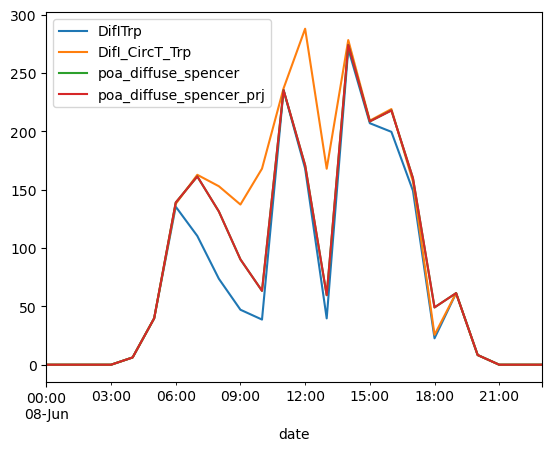

In [74]:
df.loc[(df["date"].dt.day==8) & (df["date"].dt.month==6),:].plot(x="date",y=["DifITrp","DifI_CircT_Trp",
"poa_diffuse_spencer","poa_diffuse_spencer_prj"])
# 'pyephem', 'spencer', 'asce', 'nrel'.

<AxesSubplot: xlabel='date'>

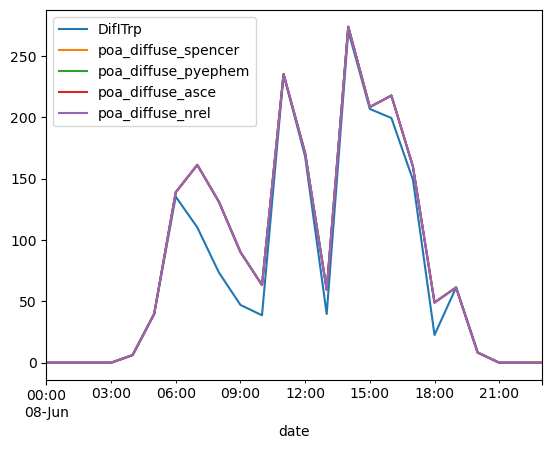

In [68]:
df.loc[(df["date"].dt.day==8) & (df["date"].dt.month==6), :].plot(x="date",y=["DifITrp",
"poa_diffuse_spencer","poa_diffuse_pyephem","poa_diffuse_asce","poa_diffuse_nrel"])
# 'pyephem', 'spencer', 'asce', 'nrel'.

In [61]:
df.loc[df["diff_pr"]==np.nanmax(df["diff_pr"]), clms]

,date,HSol,AzSol,BeamHor,BeamTrp,DiffHor,DifITrp,CircTrp,DifI_CircT_Trp,diff_pr,poa_diffuse_spencer,poa_diffuse_pyephem,poa_diffuse_asce,poa_diffuse_nrel,poa_diffuse_spencer_prj,poa_diffuse_pyephem_prj,poa_diffuse_asce_prj,poa_diffuse_nrel_prj
3756,2015-06-06 11:00:00,59.297,-15.173,865.4,995.76,171.0,37.596,149.45,187.046,77.905855,41.326214,41.434142,41.302185,41.43438,41.326214,41.434142,41.302185,41.43438


<AxesSubplot: xlabel='date'>

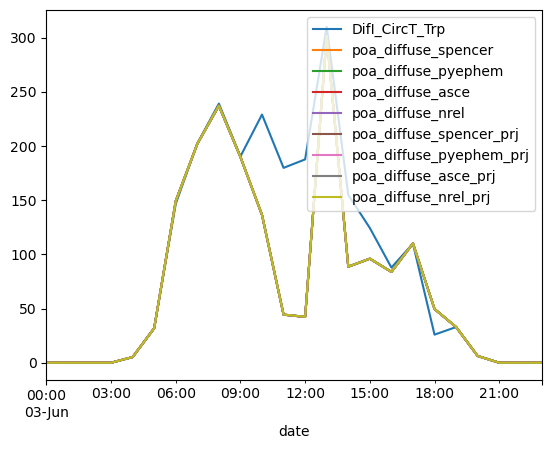

In [62]:
df.loc[(df["date"].dt.day==3) & (df["date"].dt.month==6), clms].plot(x="date",
y=["DifI_CircT_Trp","poa_diffuse_spencer","poa_diffuse_pyephem","poa_diffuse_asce","poa_diffuse_nrel",
"poa_diffuse_spencer_prj","poa_diffuse_pyephem_prj","poa_diffuse_asce_prj","poa_diffuse_nrel_prj"
])

In [63]:
clms = ["date","GlobInc","GlobEff","EArrRef","EArrMPP","IArray","UArray","EArray","EOutInv","E_Grid","Yr","PR","Lc",
"EffInvR","GlobHor","DiffHor","BeamHor","HSol","AzSol","BeamTrp","DifITrp","CircTrp","HBndTrp","AlbTrp","GlobTrp"]
clms =["date","HSol","AzSol","BeamHor","BeamTrp","DiffHor","DifITrp","CircTrp","poa_diffuse","diff_pr","DifI_CircT_Trp"]


# df.loc[df["diff_pr"]==-236.30937563925292, clms+["diff_pr2"]]

In [64]:
df.loc[(df["date"].dt.day==28) & (df["date"].dt.month==6), clms].plot(x="date",y=["DifI_CircT_Trp","poa_diffuse_spencer","poa_diffuse_pyephem","poa_diffuse_asce","poa_diffuse_nrel"])

KeyError: "['poa_diffuse'] not in index"